In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore
from matplotlib.colors import LogNorm

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# weird behaviour from this example
mouse = 25
day = 25
session_type = 'OF1'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/COHORT12_nolfp')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)



In [3]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
list(tuning_scores)

['hd_mean_vector_length',
 'grid_score',
 'theta_index',
 'speed_correlation',
 'ellipse_grid_score',
 'spatial_information']

In [4]:
def min_max_normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def find_set(a, b):
    return set(a) & set(b)

In [5]:
def calc_ego_autocorr(spike_times, session):
    t = session['P_x'].index
    x = session['P_x'].values
    y = session['P_y'].values
    hd = session['H'].values

    x = np.interp(spike_times, t, x)
    y = np.interp(spike_times, t, y)
    hd = np.interp(spike_times, t, hd)

    x_spike_stack = np.vstack([x]*len(x))
    y_spike_stack = np.vstack([y]*len(y))

    x_spike_stack = x_spike_stack - x[:,None]
    y_spike_stack = y_spike_stack - y[:,None]

    tmp1 = (np.cos(hd)[:,None]*x_spike_stack).astype(np.int8)
    tmp2 = (np.sin(hd)[:,None]*y_spike_stack).astype(np.int8)
    rotated_pos_from_spikes_x = tmp1 - tmp2

    tmp1 = (np.sin(hd)[:,None]*x_spike_stack).astype(np.int8)
    tmp2 = (np.cos(hd)[:,None]*y_spike_stack).astype(np.int8)
    rotated_pos_from_spikes_y = tmp1 + tmp2

    rotated_pos_from_spikes_x = rotated_pos_from_spikes_x.astype(np.int16).flatten()
    rotated_pos_from_spikes_y = rotated_pos_from_spikes_y.astype(np.int16).flatten()

    autocorrelogram_2d, xedges, yedges = np.histogram2d(rotated_pos_from_spikes_x, 
                                                        rotated_pos_from_spikes_y,
                                                        bins=[200,200], 
                                                        range=[[-100, 100], [-100, 100]], 
                                                        density=False)

    euclidean_distances = np.sqrt((np.square(rotated_pos_from_spikes_x)
                                   +np.square(rotated_pos_from_spikes_y)))

    autocorrelogram_1d, bin_edges = np.histogram(euclidean_distances, bins=150, range=[0, 150], density=False)

    autocorrelogram_2d[100,100] = autocorrelogram_2d[100,99] # negate the middle point

    return autocorrelogram_2d, autocorrelogram_1d, bin_edges

In [6]:
cluster_ids_ordered = np.array(tuning_scores['grid_score'].sort_values(by='grid_score', ascending=False, na_position='last')['cluster_id'])

for index in cluster_ids_ordered:
    neuron = neurons[neurons.index == index]
    spike_times = np.array(neuron[index].index)
    print(f'neuron {index}, has {len(spike_times)} spikes')


neuron 11, has 3045 spikes
neuron 287, has 9408 spikes
neuron 238, has 2572 spikes
neuron 106, has 1456 spikes
neuron 291, has 8941 spikes
neuron 240, has 1782 spikes
neuron 249, has 2137 spikes
neuron 322, has 529 spikes
neuron 181, has 4855 spikes
neuron 235, has 8120 spikes
neuron 312, has 7880 spikes
neuron 250, has 5910 spikes
neuron 247, has 773 spikes
neuron 16, has 10755 spikes
neuron 127, has 1614 spikes
neuron 222, has 4379 spikes
neuron 295, has 6949 spikes
neuron 196, has 6627 spikes
neuron 109, has 10212 spikes
neuron 92, has 1371 spikes
neuron 97, has 3118 spikes
neuron 120, has 5833 spikes
neuron 232, has 40428 spikes
neuron 193, has 7023 spikes
neuron 149, has 5045 spikes
neuron 227, has 7401 spikes
neuron 205, has 23556 spikes
neuron 197, has 7839 spikes
neuron 101, has 7672 spikes
neuron 293, has 8102 spikes
neuron 79, has 3378 spikes
neuron 73, has 4580 spikes
neuron 245, has 10176 spikes
neuron 191, has 4732 spikes
neuron 220, has 9487 spikes
neuron 111, has 7212 sp

In [12]:
np.array(tuning_scores['grid_score'].sort_values(by='grid_score', ascending=False, na_position='last')['grid_score'])

array([ 1.22821866,  0.47079897,  0.37799828,  0.34238957,  0.29689332,
        0.29464655,  0.29028417,  0.28161635,  0.25599579,  0.21040797,
        0.17937097,  0.17767272,  0.14746475,  0.14330733,  0.14008328,
        0.13364106,  0.13128646,  0.12625398,  0.11845995,  0.09250323,
        0.08530451,  0.08158042,  0.07509412,  0.07497722,  0.07260546,
        0.0659384 ,  0.0614792 ,  0.02203664,  0.0191749 ,  0.00504707,
       -0.00929949, -0.04042155, -0.04109442, -0.04831406, -0.05379326,
       -0.06031413, -0.06603421, -0.07167122, -0.07451433, -0.0768222 ,
       -0.08384865, -0.08587088, -0.09178892, -0.0971312 , -0.10981848,
       -0.12059687, -0.12147187, -0.12869877, -0.13281724, -0.1416429 ,
       -0.15412423, -0.15856248, -0.17445482, -0.17655329, -0.17819364,
       -0.17911445, -0.18150375, -0.18585179, -0.19403037, -0.20120833,
       -0.20924773, -0.21667205, -0.2182408 , -0.22124278, -0.2240508 ,
       -0.2253109 , -0.22608863, -0.23381843, -0.23513695, -0.23

In [7]:
bin_config = get_bin_config(session_type)[('P_x', 'P_y')]
cluster_ids_ordered = np.array(tuning_scores['grid_score'].sort_values(by='grid_score', ascending=False, na_position='last')['cluster_id'])

norm_autocorr_2ds = []
norm_autocorr_1ds = []

for i, index in enumerate(cluster_ids_ordered):
    neuron = neurons[neurons.index == index]
    spike_times = np.array(neuron[index].index)
    print(f'{i}/{len(cluster_ids_ordered)}, neuron {index}, has {len(spike_times)} spikes')
    if len(spike_times)>7500:
        spike_times=spike_times[:7500]
        print(f'reduced the spike count down for neuron {index}, to {len(spike_times)} spikes')


    # completely random additions for each spike here
    random_firing_addititions = np.random.randint(low=20, 
                                                  high=np.nanmax(spike_times)-20, 
                                                  size=len(spike_times))
    shf_spike_times = spike_times + random_firing_addititions
    shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] = shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] - np.nanmax(spike_times) # wrap around
    shf_spike_times = np.sort(shf_spike_times)

    autocorr_2d, autocorr_1d, bin_edges = calc_ego_autocorr(spike_times, session)
    shf_autocorr_2d, shf_autocorr_1d, bin_edges = calc_ego_autocorr(shf_spike_times, session)

    diff_autocorr_2d = autocorr_2d-shf_autocorr_2d
    #autocorr_2d = min_max_normalize(autocorr_2d)
    #shf_autocorr_2d = min_max_normalize(shf_autocorr_2d)
    #diff_autocorr_2d = min_max_normalize(diff_autocorr_2d)

    diff_autocorr_1d = autocorr_1d-shf_autocorr_1d

    norm_autocorr_2ds.append(diff_autocorr_2d)
    norm_autocorr_1ds.append(diff_autocorr_1d)

    '''
    vmax=1
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), squeeze=False)
    ax[0,0].imshow(autocorr_2d, interpolation='none', cmap='inferno', norm=LogNorm(), origin='lower')
    ax[0,0].set_title(f'autocorr, cluster {index}')
    ax[0,1].imshow(shf_autocorr_2d, interpolation='none', cmap='inferno', norm=LogNorm(), origin='lower')
    ax[0,1].set_title(f'shuffled autocorr, cluster {index}')
    ax[0,2].imshow(diff_autocorr_2d, interpolation='none', cmap='inferno', norm=LogNorm(), origin='lower')
    ax[0,2].set_title(f'diff autocorr, cluster {index}')
    plt.show()
    
    vmax=0.5
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), squeeze=False)
    ax[0,0].imshow(autocorr_2d, interpolation='none', cmap='inferno', vmin=0, vmax=vmax, origin='lower')
    ax[0,0].set_title(f'autocorr, cluster {index}')
    ax[0,1].imshow(shf_autocorr_2d, interpolation='none', cmap='inferno', vmin=0, vmax=vmax, origin='lower')
    ax[0,1].set_title(f'shuffled autocorr, cluster {index}')
    ax[0,2].imshow(diff_autocorr_2d, interpolation='none', cmap='inferno', vmin=0, vmax=vmax, origin='lower')
    ax[0,2].set_title(f'diff autocorr, cluster {index}')
    plt.show()

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), squeeze=False)
    bin_centres = 0.5*(bin_edges[1:]+bin_edges[:-1])
    ax[0,0].bar(bin_centres, autocorr_1d, color="black", edgecolor="black", align="edge")
    ax[0,0].set_title(f'autocorr, cluster {index}')
    ax[0,1].bar(bin_centres, shf_autocorr_1d, color="black", edgecolor="black", align="edge")
    ax[0,1].set_title(f'shuffled autocorr, cluster {index}')
    ax[0,2].bar(bin_centres, diff_autocorr_1d, color="black", edgecolor="black", align="edge")
    ax[0,2].set_title(f'diff autocorr, cluster {index}')
    plt.show()
    '''


neuron 11, has 3045 spikes
neuron 287, has 9408 spikes
reduced the spike count down for neuron 287, to 7500 spikes
neuron 238, has 2572 spikes
neuron 106, has 1456 spikes
neuron 291, has 8941 spikes
reduced the spike count down for neuron 291, to 7500 spikes
neuron 240, has 1782 spikes
neuron 249, has 2137 spikes
neuron 322, has 529 spikes
neuron 181, has 4855 spikes
neuron 235, has 8120 spikes
reduced the spike count down for neuron 235, to 7500 spikes
neuron 312, has 7880 spikes
reduced the spike count down for neuron 312, to 7500 spikes
neuron 250, has 5910 spikes
neuron 247, has 773 spikes
neuron 16, has 10755 spikes
reduced the spike count down for neuron 16, to 7500 spikes
neuron 127, has 1614 spikes
neuron 222, has 4379 spikes
neuron 295, has 6949 spikes
neuron 196, has 6627 spikes
neuron 109, has 10212 spikes
reduced the spike count down for neuron 109, to 7500 spikes
neuron 92, has 1371 spikes
neuron 97, has 3118 spikes
neuron 120, has 5833 spikes
neuron 232, has 40428 spikes


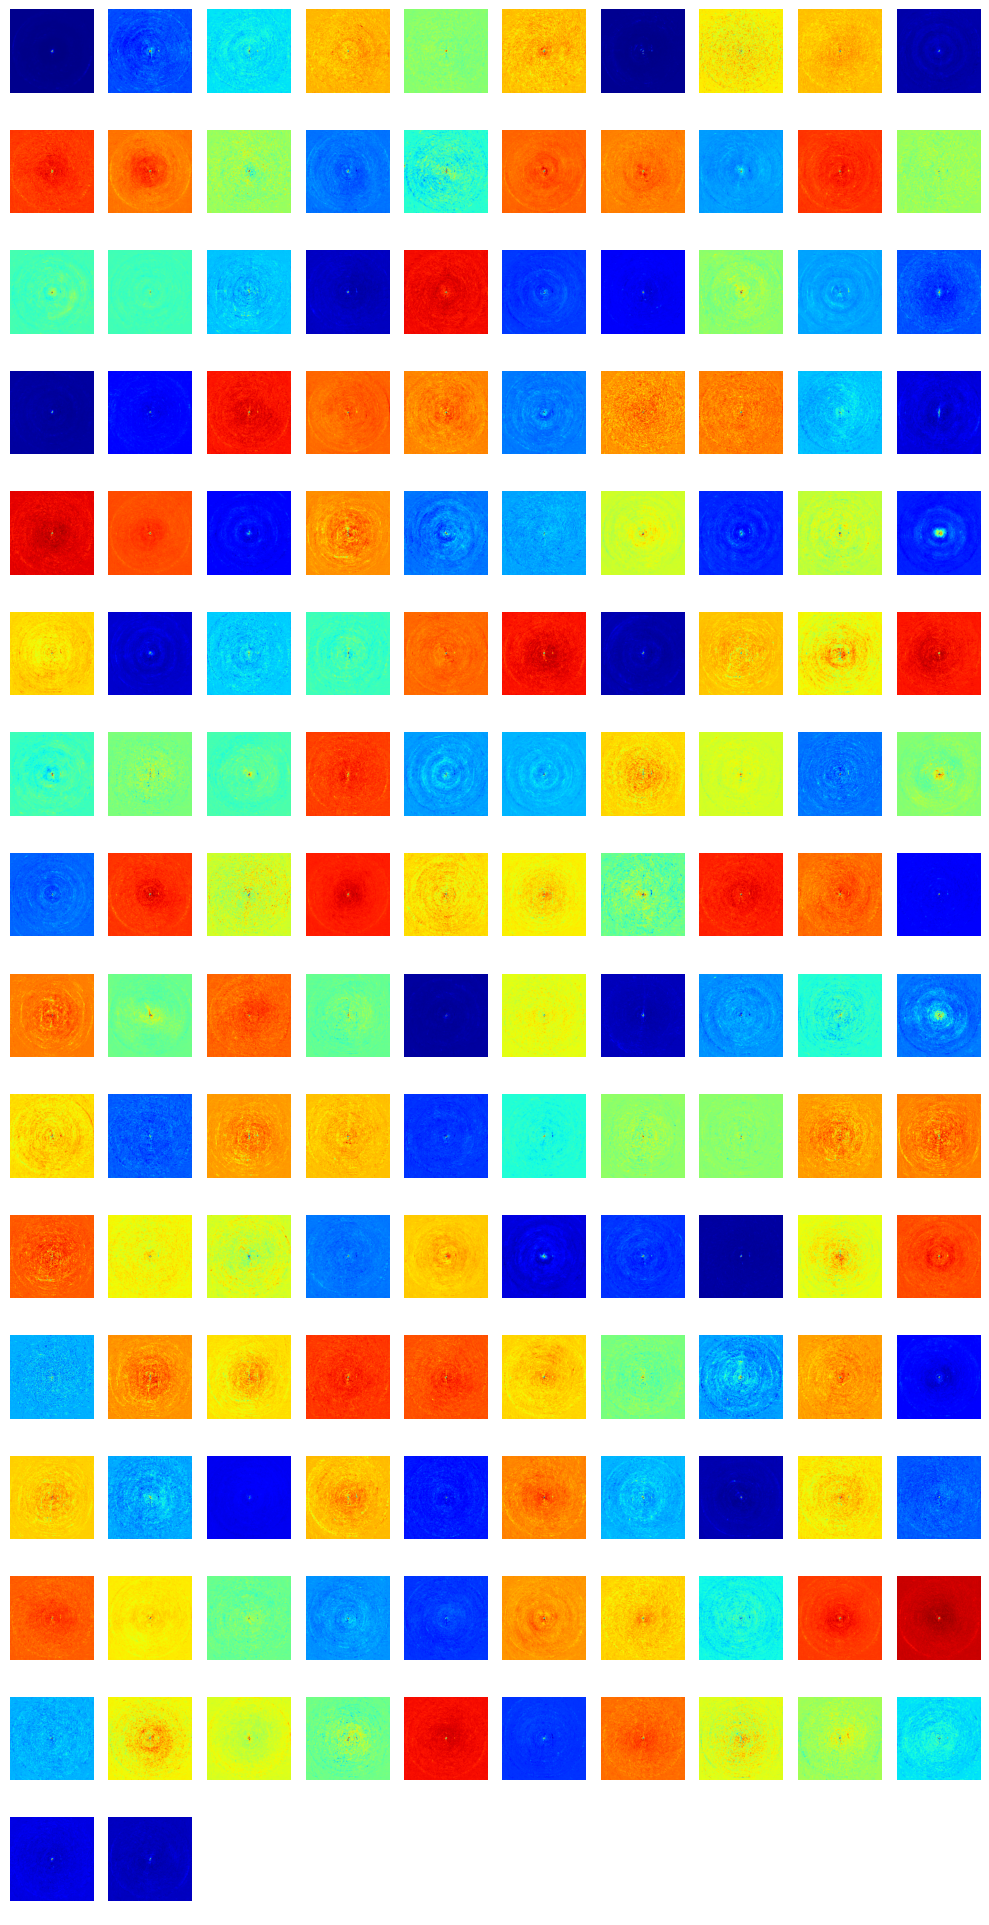

In [16]:
# Plot
ncols = 10
nrows = int(np.ceil(len(norm_autocorr_2ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(norm_autocorr_2ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(norm_autocorr_2ds):
            ax[j, i].imshow(norm_autocorr_2ds[counter], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

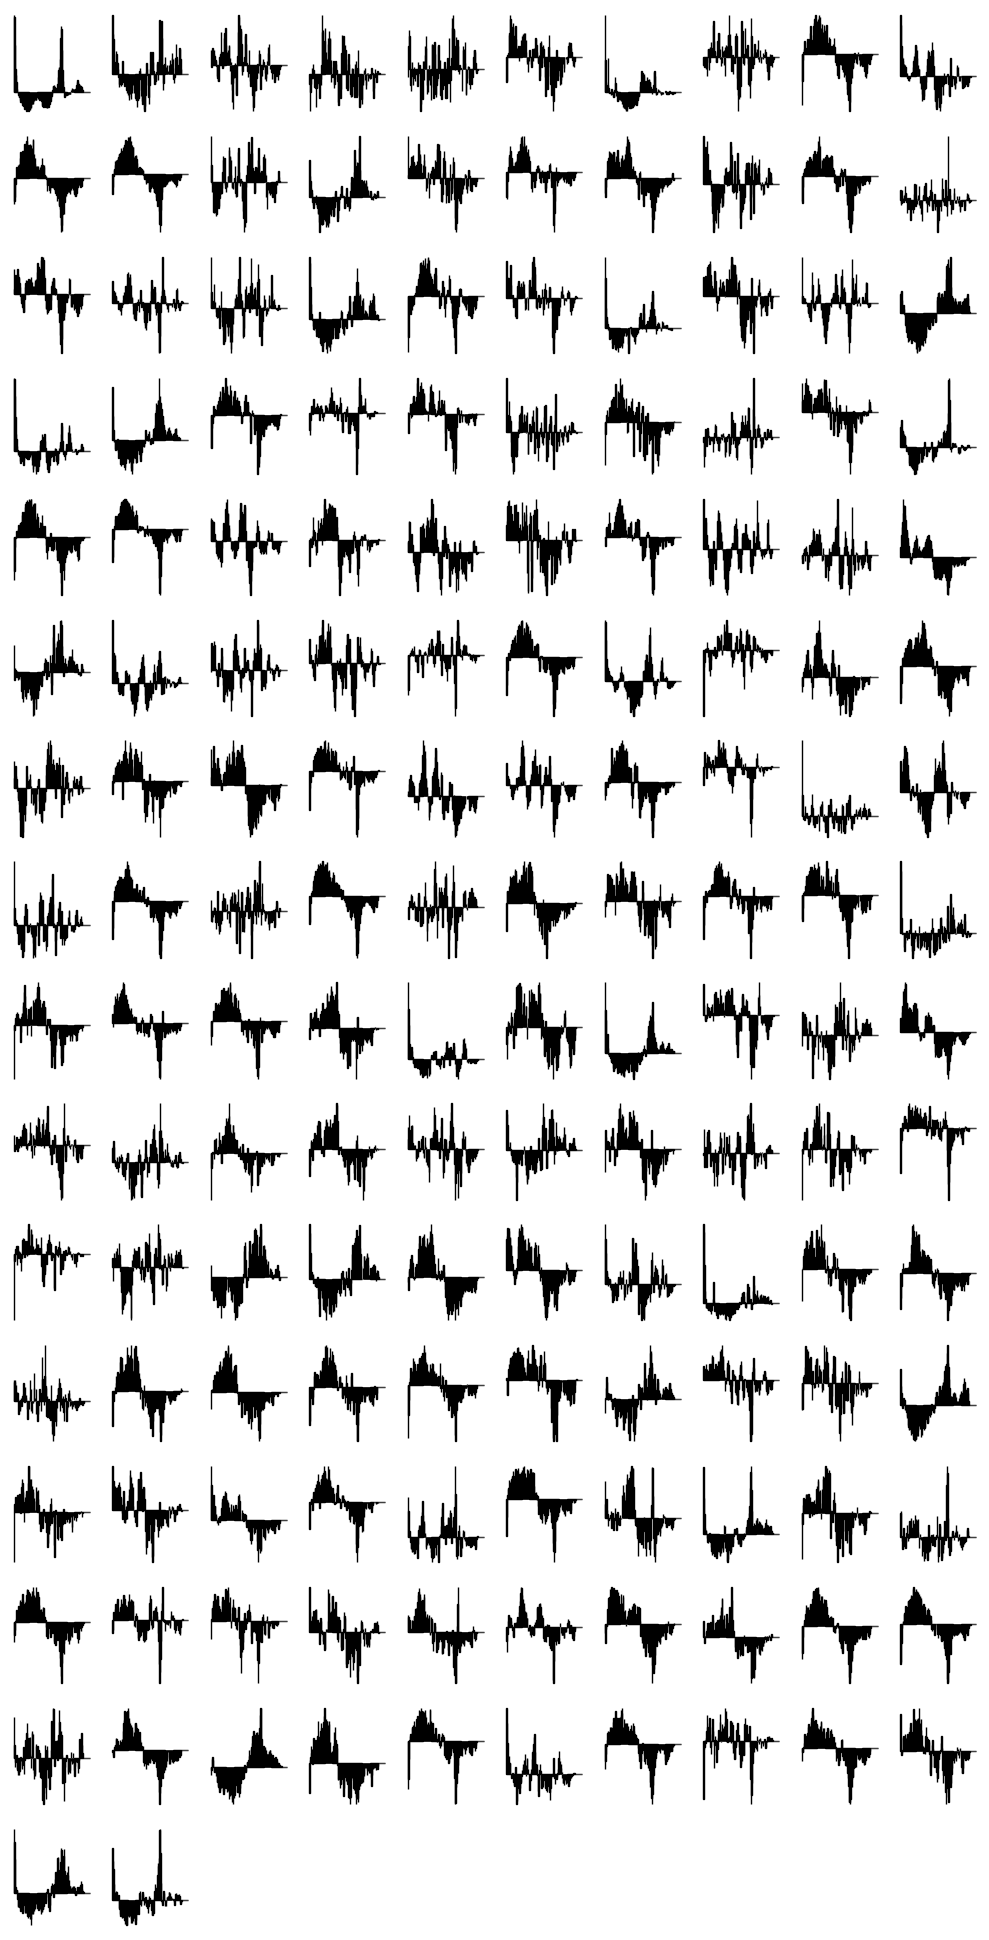

In [13]:
# Plot
bin_centres = 0.5*(bin_edges[1:]+bin_edges[:-1])

ncols = 10
nrows = int(np.ceil(len(norm_autocorr_1ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(norm_autocorr_1ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(norm_autocorr_1ds):
            ax[j, i].bar(bin_centres, norm_autocorr_1ds[counter],
                          color="black", edgecolor="black", align="edge")
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()